In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# this will calculate the angular 
# and energy resolution histograms
# %run ../../core/resolution.py
#--renew_calc
# %run ../../core/prepare_histograms.py
## -> only run this if you need to update the histograms

# Import

In [3]:
import pickle
from os.path import join
import numpy as np
import seaborn as sns
from settings import *

from resolution import comb, g_norm, double_erf


Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Load resolution baseline

In [4]:
with open(join(LOCALPATH, "energy_smearing_GP_up.pckl"), "rb") as f:
    eres_up_mh = pickle.load(f)


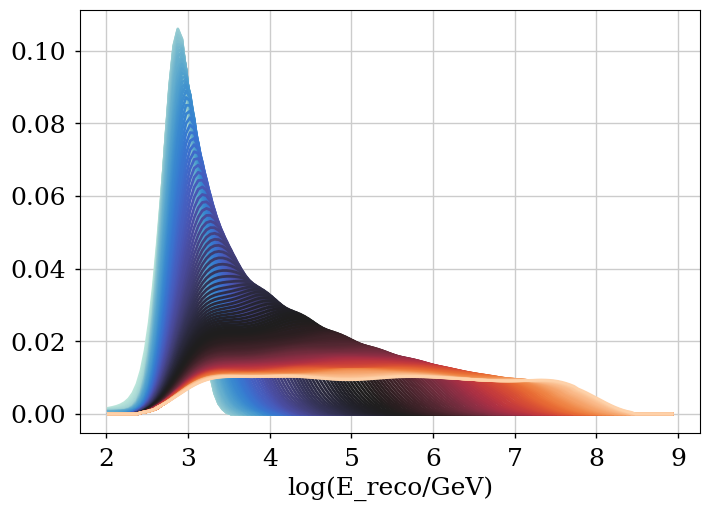

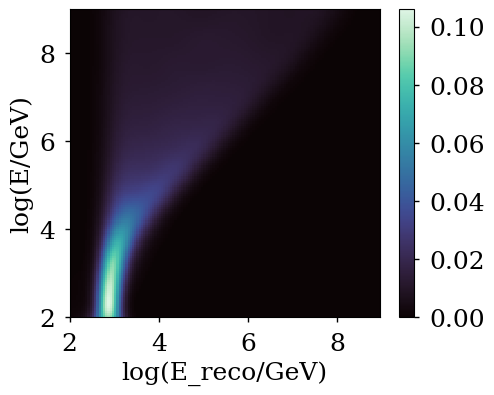

In [5]:
sns.set_palette("icefire", n_colors=eres_up_mh.shape[1] + 1)
_ = plt.plot(eres_up_mh.bin_mids[1], eres_up_mh.histo.T)
plt.xlabel(eres_up_mh.axis_names[1])
eres_up_mh.T().plot()

# crosscheck with raw original resolution

In [6]:
from resolution import read_smearing_matrix

In [7]:
public_data_df = read_smearing_matrix()
log_sm_emids = (public_data_df["logE_nu_min"] + public_data_df["logE_nu_max"]) / 2.0
log_sm_ereco_mids = (public_data_df["logE_reco_min"] + public_data_df["logE_reco_max"]) / 2.0
fractional_event_counts = public_data_df["Fractional_Counts"]
dec_sm_min, dec_sm_max = public_data_df["Dec_nu_min"], public_data_df["Dec_nu_max"]
dec_sm_mids = (dec_sm_min + dec_sm_max) / 2.0

# down-going (=South): -90 -> -10 deg
# horizontal: -10 -> 10 deg
# up-going (=North): 10 -> 90 deg

In [8]:
ebins = np.sort(
    np.unique(
        np.concatenate([public_data_df["logE_nu_min"], public_data_df["logE_nu_max"]])
    )
)
erecobins = np.sort(
    np.unique(
        np.concatenate([public_data_df["logE_reco_min"], public_data_df["logE_reco_max"]])
    )
)
erecobins = np.linspace(np.min(erecobins), np.max(erecobins), num=len(ebins)+1)


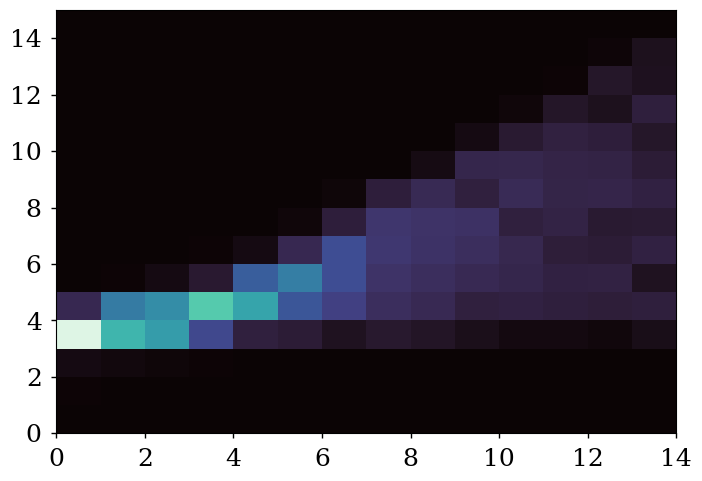

In [14]:
plt.pcolormesh(hists[0.0] + hists[50.0])

In [13]:
hists.keys()

dict_keys([-50.0, 0.0, 50.0])

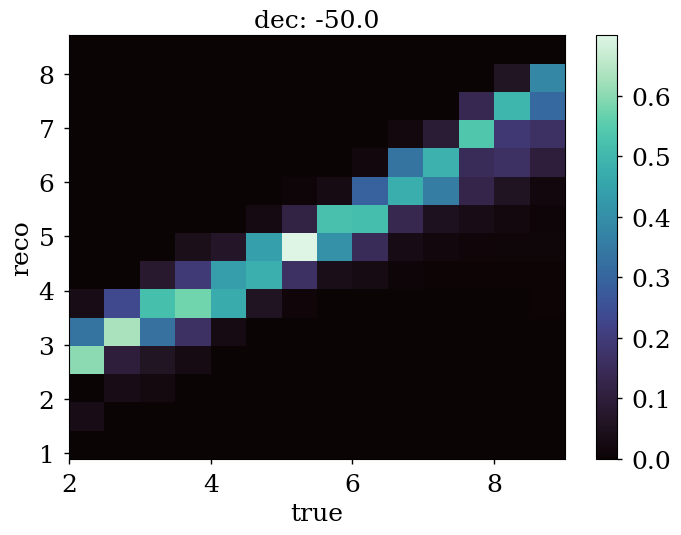

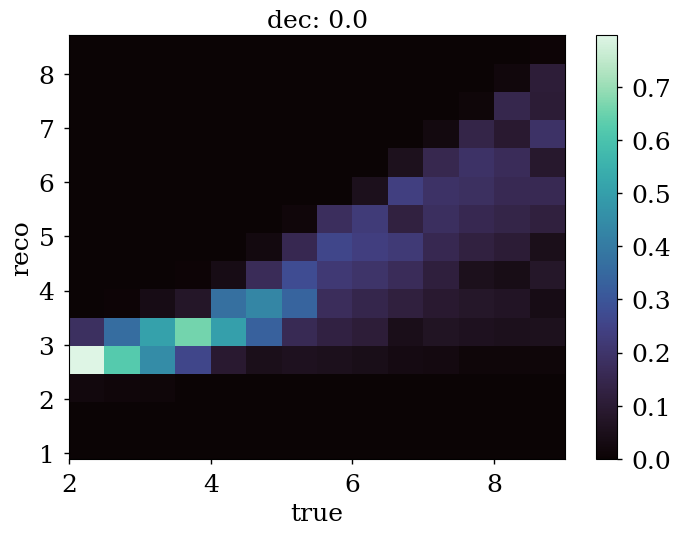

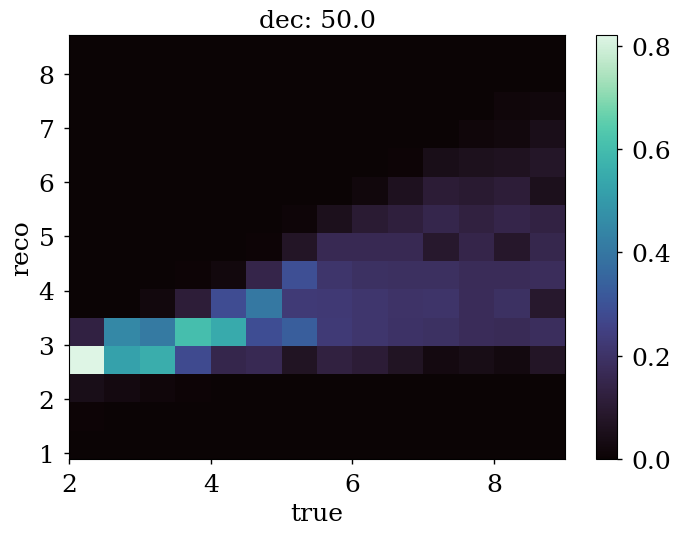

In [9]:
hists = {}
# loop over declination bins
for dd in np.unique(dec_sm_mids):
    dec_mask = dec_sm_mids == dd
    # energy resolution per declination bin
    h, xed, yed = np.histogram2d(
        log_sm_emids[dec_mask],
        log_sm_ereco_mids[dec_mask],
        weights=fractional_event_counts[dec_mask],
        bins=(ebins, erecobins),
    )
    # normalize per bin in true energy
    h = h.T / np.sum(h, axis=1)
    hists[dd] = h
    plt.figure()
    plt.title(f"dec: {dd}")
    plt.pcolormesh(xed, yed, h)
    plt.xlabel("true")
    plt.ylabel("reco")
    plt.colorbar()

# Parametrizations

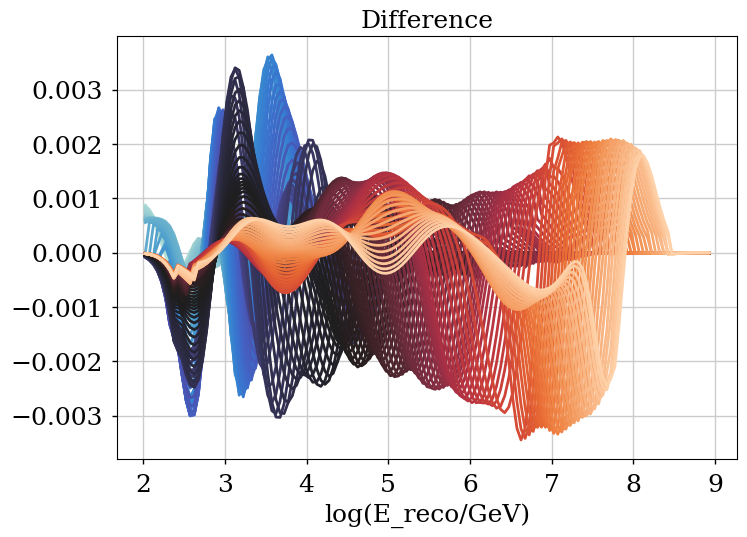

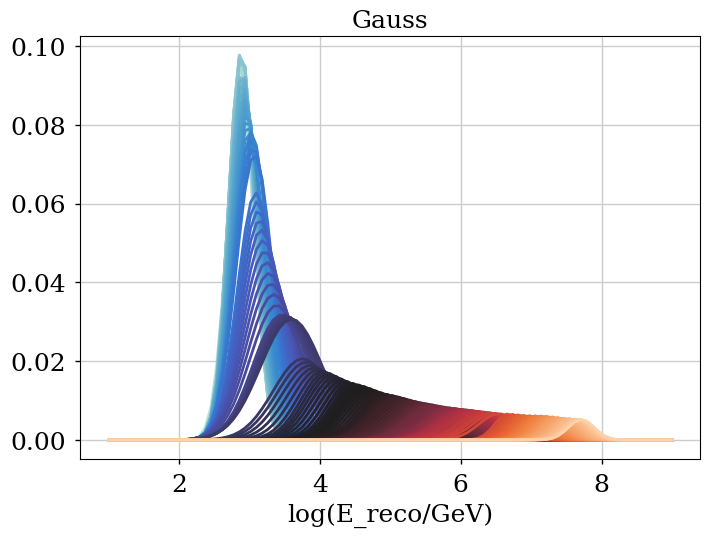

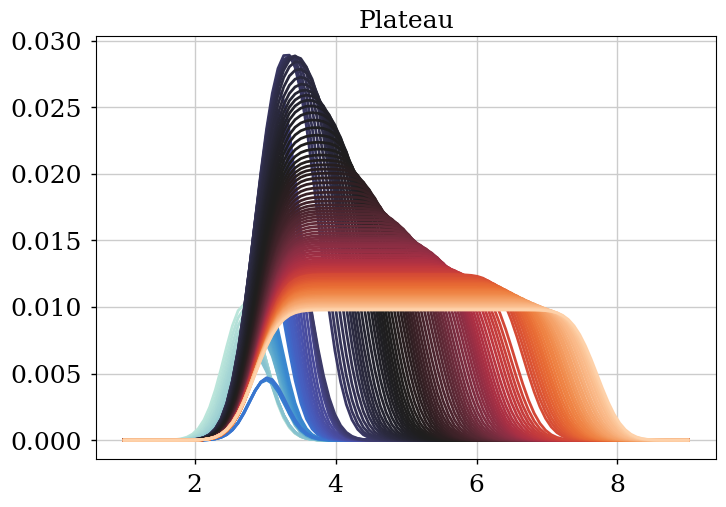

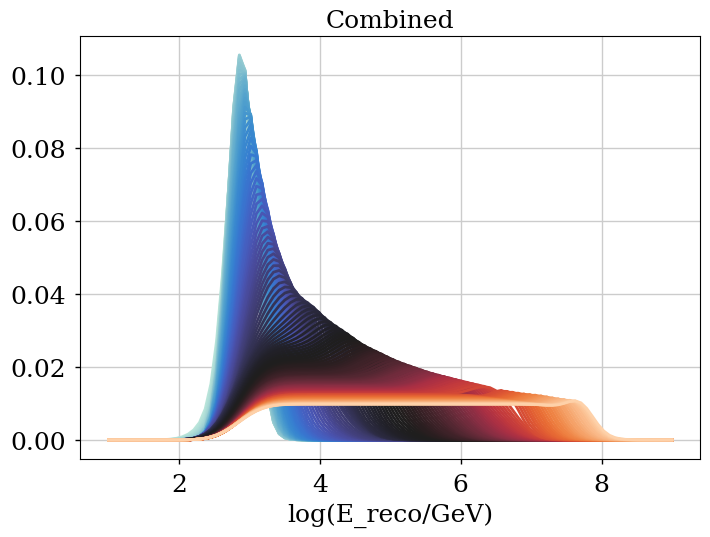

In [6]:
fit_params = np.load(join(LOCALPATH, "Eres_fits_GP.npy"))
xvals = np.linspace(1, 9, num=100)
for ii, et in enumerate(eres_up_mh.bin_mids[0]):
    cur_params = list(fit_params[ii])
    plt.figure(-1)
    plt.title("Difference")
    p = plt.plot(
        eres_up_mh.bin_mids[1],
        eres_up_mh.histo[ii] - comb(eres_up_mh.bin_mids[1], *cur_params),
    )
    plt.xlabel(eres_up_mh.axis_names[1])

    plt.figure(1)
    plt.title("Gauss")
    plt.plot(
        xvals,
        g_norm(xvals, *cur_params[-3:]),
        color=p[0].get_color(),
        lw=2,
    )
    plt.xlabel(eres_up_mh.axis_names[1])
        
    plt.figure(3)
    plt.title("Plateau")
    plt.plot(
        xvals,
        double_erf(xvals, *[cur_params[i] for i in (0, 2, 1)]),
        color=p[0].get_color(),
        lw=2,
    )
    plt.figure(2)
    plt.title("Combined")
    plt.plot(
        xvals,
        comb(xvals, *cur_params),
        color=p[0].get_color(),
        lw=2,
        zorder=10,
    )
    plt.xlabel(eres_up_mh.axis_names[1])



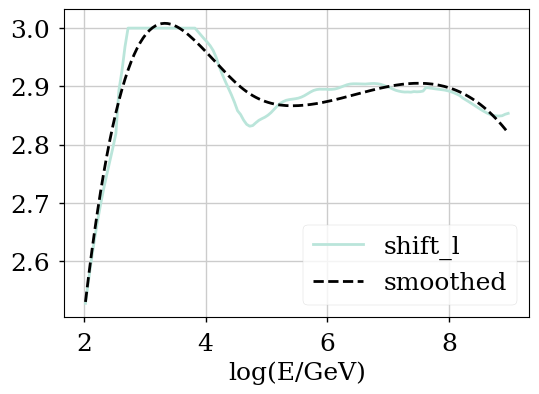

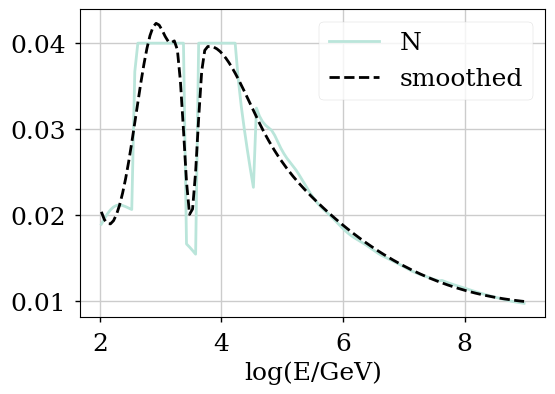

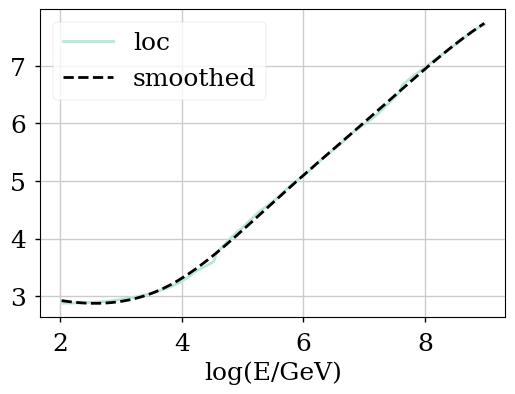

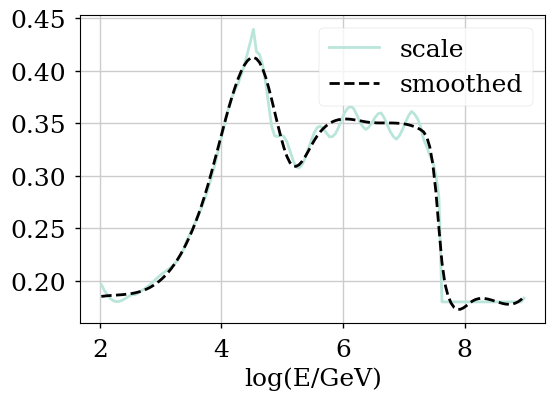

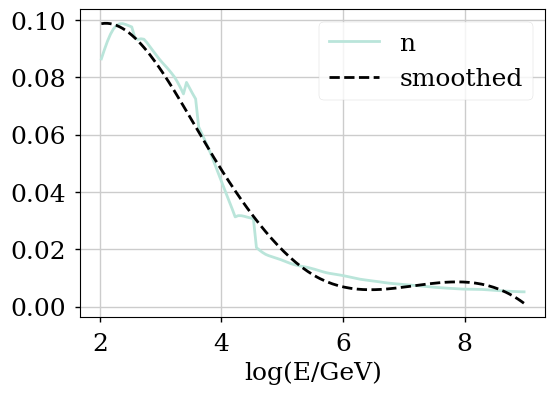

In [7]:
smoothed_fit_params = np.load(join(LOCALPATH, "Eres_fits_smoothed_GP.npy"))

for n in fit_params.dtype.names:
    plt.figure(figsize=(6, 4))
    p = plt.plot(eres_up_mh.bin_mids[0], fit_params[n], label=n)
    p = plt.plot(
        eres_up_mh.bin_mids[0],
        smoothed_fit_params[n],
        label="smoothed",
        color="k",
        ls="--",
    )
    plt.xlabel(eres_up_mh.axis_names[0])
    plt.legend()


# Artificial smearing matrices

## Best reproduction

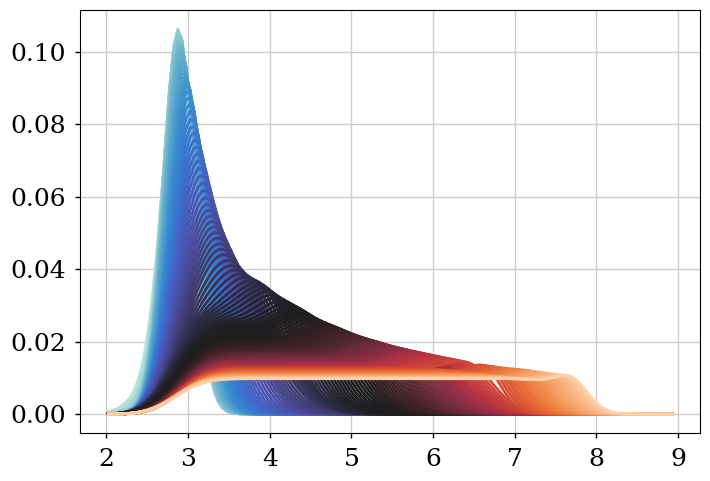

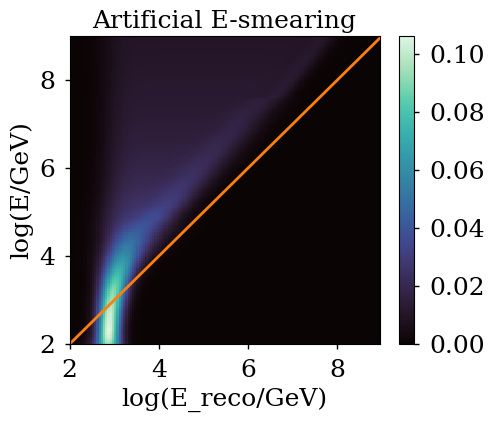

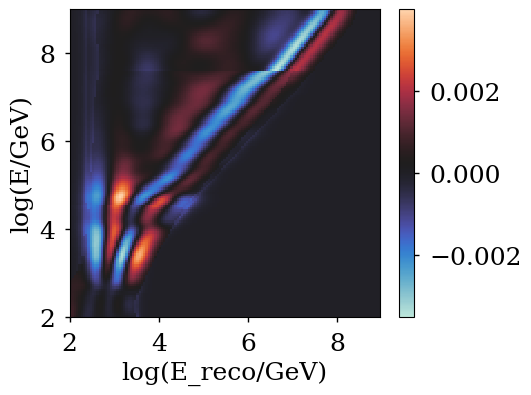

In [8]:
with open(join(LOCALPATH, "artificial_energy_smearing_GP_up.pckl"), "rb") as f:
    artificial_2D = pickle.load(f)

_ = plt.plot(artificial_2D.bin_mids[1], artificial_2D.histo.T)

artificial_2D.T().plot()
plt.plot([E_MIN, E_MAX], [E_MIN, E_MAX], color="tab:orange")

plt.title("Artificial E-smearing")

(eres_up_mh - artificial_2D).T().plot(cmap="icefire")


## Smoothed reproduction


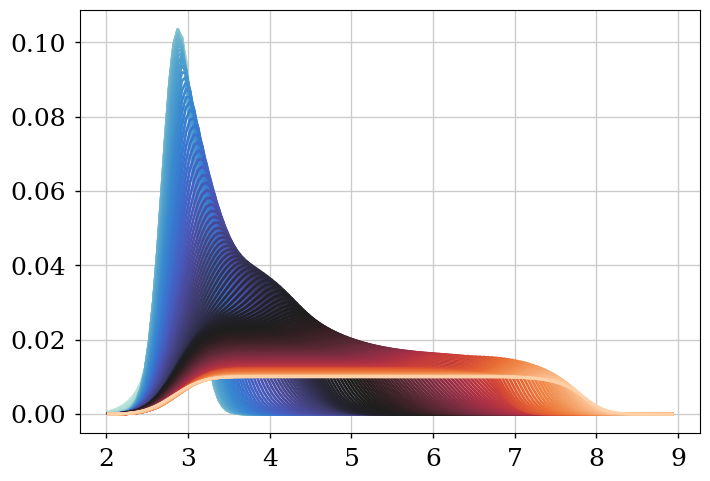

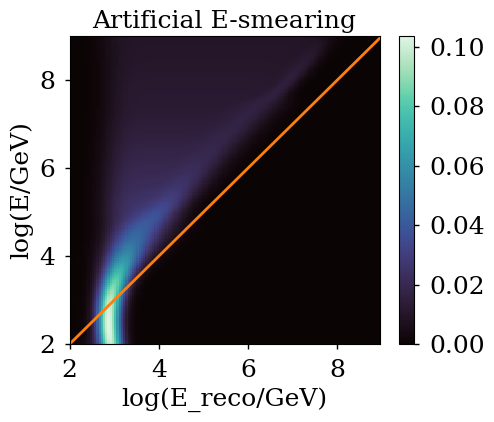

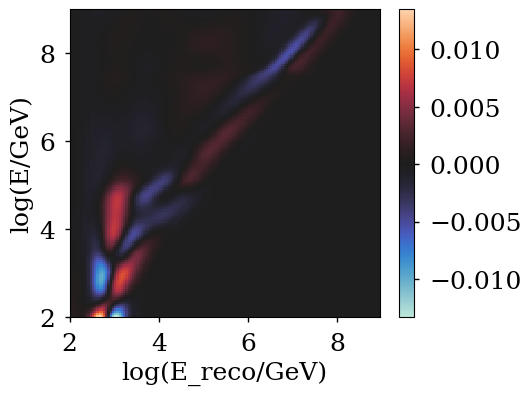

In [9]:
with open(join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"), "rb") as f:
    artificial_2D = pickle.load(f)

_ = plt.plot(artificial_2D.bin_mids[1], artificial_2D.histo.T)

artificial_2D.T().plot()
plt.plot([E_MIN, E_MAX], [E_MIN, E_MAX], color="tab:orange")

plt.title("Artificial E-smearing")

(eres_up_mh - artificial_2D).T().plot(cmap="icefire")


## 1:1 reco reproduction

Text(0.5, 1.0, 'Artificial E-smearing 1:1')

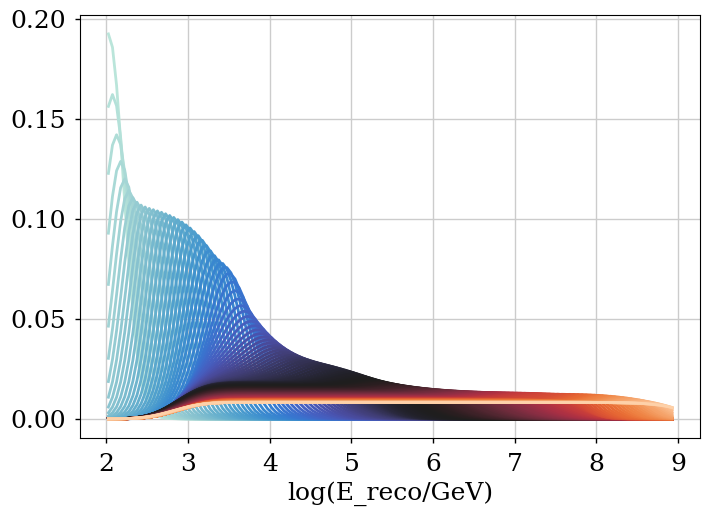

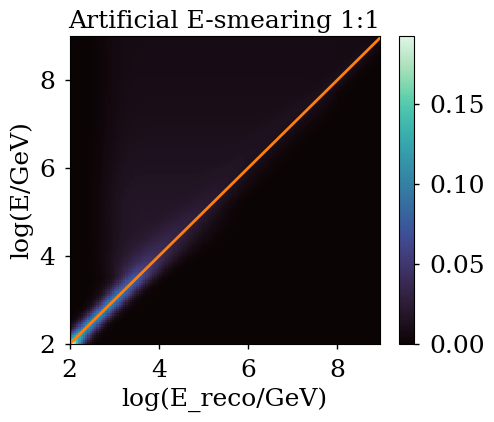

In [10]:
with open(join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"), "rb") as f:
    artificial_one2one = pickle.load(f)
_ = plt.plot(artificial_one2one.bin_mids[1], artificial_one2one.histo.T)
plt.xlabel(artificial_one2one.axis_names[1])

artificial_one2one.T().plot()
plt.plot([E_MIN, E_MAX], [E_MIN, E_MAX], color="tab:orange")

plt.title("Artificial E-smearing 1:1")


## Improved artificial energy smearing

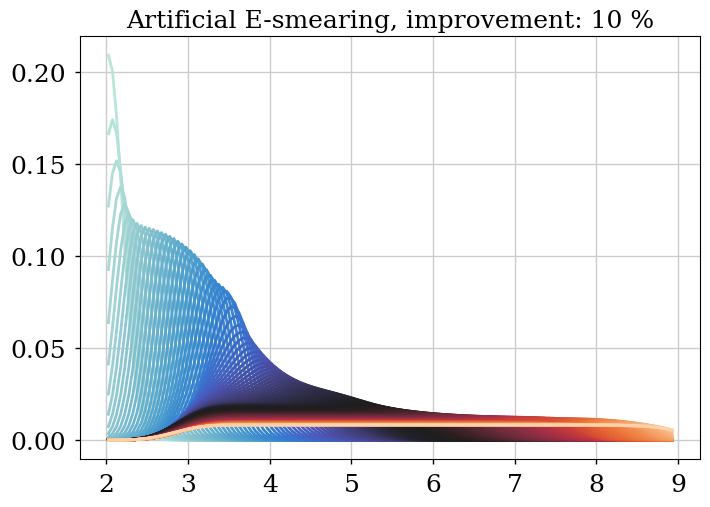

<Figure size 800x550 with 0 Axes>

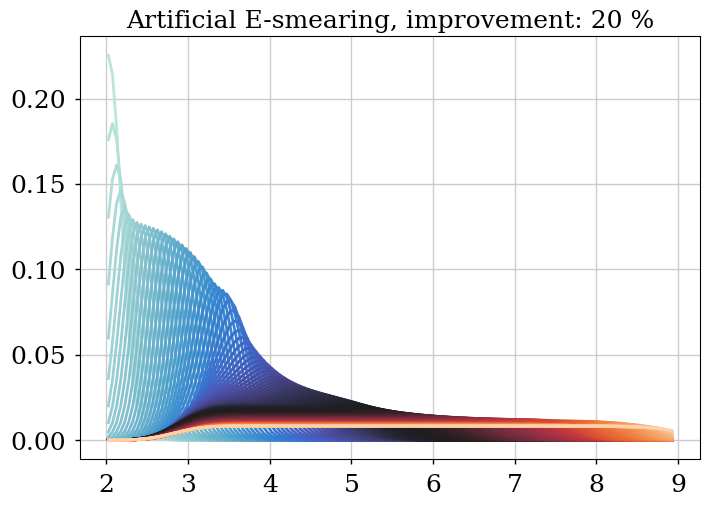

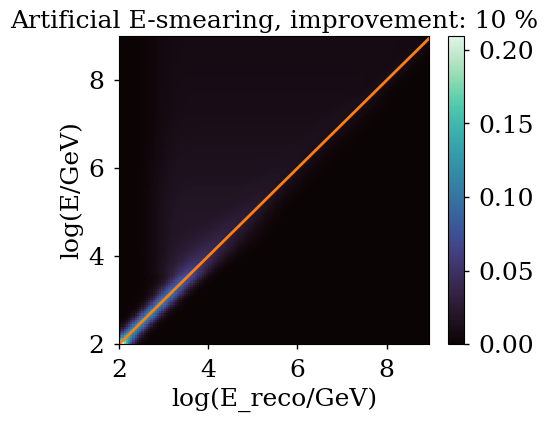

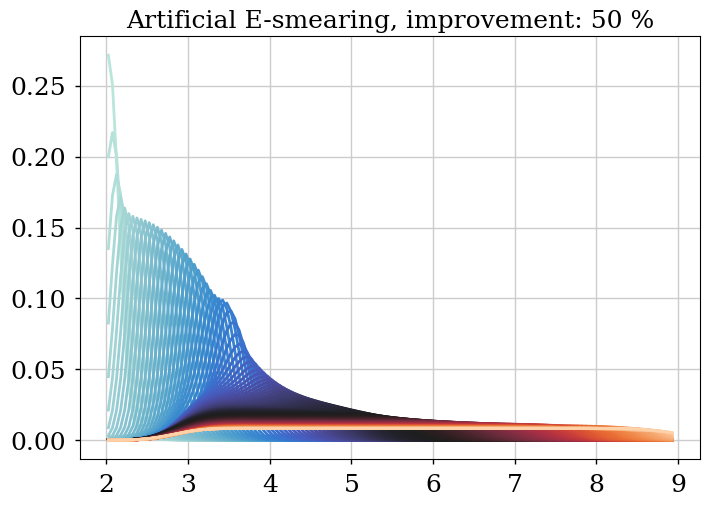

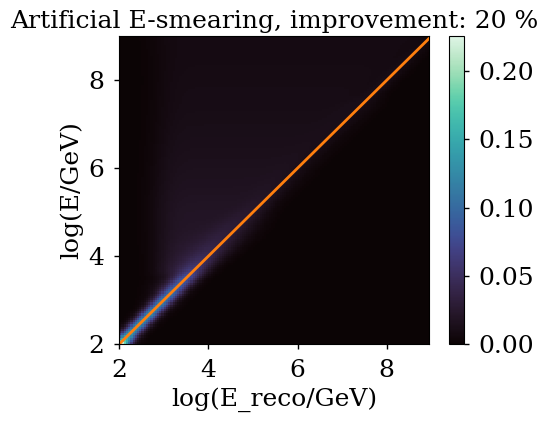

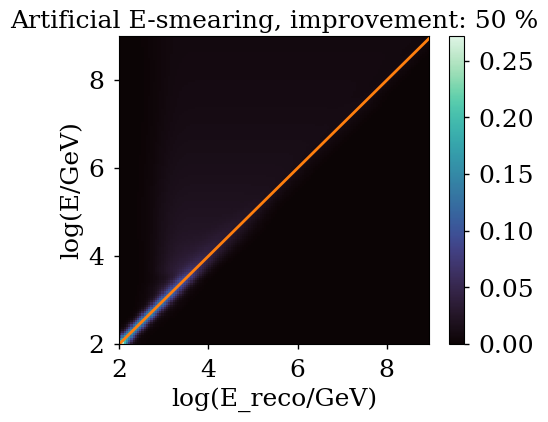

In [11]:
for ii, impro_factor in enumerate([0.1, 0.2, 0.5]):
    filename = join(
        LOCALPATH,
        f"improved_{impro_factor}_artificial_energy_smearing_GP_up.pckl",
    )
    with open(filename, "rb") as f:
        artificial_2D_impro = pickle.load(f)
    plt.figure(ii)
    plt.title(f"Artificial E-smearing, improvement: {impro_factor*100:1.0f} %")
    _ = plt.plot(artificial_2D_impro.bin_mids[1], artificial_2D_impro.histo.T)

    plt.figure(ii + 20)
    artificial_2D_impro.T().plot()
    plt.plot([E_MIN, E_MAX], [E_MIN, E_MAX], color="tab:orange")
    
    plt.title(f"Artificial E-smearing, improvement: {impro_factor*100:1.0f} %")


# UHE energy smearing
-- not yet updated -- see ../sandbox/energy_resolution_test.ipynb